# Libraries

In [357]:
# Data manipularion and calculations
import pandas as pd
import numpy as np
import datetime as dt
import openpyxl as oxl

# Normalization of data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Clustering
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn.metrics import silhouette_score

# Loading dataset

In [358]:
# Importing data
df_original = pd.read_csv("C:\\Users\\franc\\Desktop\\Master\\3. 3rd trimester\\4. Marketing Analytics\\2. Project\\orders\\orders.csv")

In [359]:
# Copy the original dataset for further manipulation
df_orders = df_original

In [360]:
# See first 5 rows
df_orders.head(5)

,date,CustomerId,country,InvoiceId,SKU,productPrice,productQuantity
0,20220306,W+/urQ+lvYCXdf37dJTyrA==,France,FKXBAVNq4n8BWX6+6l1aMw==,Lfjws/JhrpyRoHlYRUMxtg==,220.19,21
1,20211127,5/eS7O5Ro6I94Chkt6rQ+A==,France,WX/ToOWAjacROJlaZEeOsA==,fnSwuwESnCH4bbuOqJ6XSg==,35.95,18
2,20220208,1byaWNzbtt3Dd22flIT0HQ==,France,U9UM4Yn15kGrLt7Cf8i4dA==,IW9+FcC0FkhK/0AZbKcpLg==,11.25,20
3,20220221,qaCW4Qt9Pciz5szTPc3m/w==,France,A0+ugv2+0kzuL4walxfdpA==,0TBa0UMTSsCmMjEEuuMymQ==,44.82,24
4,20211206,hLVOJIWxiYeXElCnXvCJeA==,France,JzuJXLEftuEp/uBXe72e4A==,EtL0UCBNtp6hAWSmWBkRrw==,179.77,15


In [361]:
# Check data type
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422813 entries, 0 to 4422812
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             int64  
 1   CustomerId       object 
 2   country          object 
 3   InvoiceId        object 
 4   SKU              object 
 5   productPrice     float64
 6   productQuantity  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 236.2+ MB


In [362]:
# Attributes description
df_orders.describe()

,date,productPrice,productQuantity
count,4.422813e+06,4.422813e+06,4.422813e+06
mean,2.021248e+07,2.496954e+01,3.869574e+00
std,3.792748e+03,3.738606e+01,2.044914e+01
min,2.021010e+07,0.000000e+00,1.000000e+00
25%,2.021031e+07,8.850000e+00,1.000000e+00
50%,2.021080e+07,1.498000e+01,2.000000e+00
75%,2.021113e+07,2.830000e+01,4.000000e+00
max,2.022032e+07,5.033700e+03,1.080000e+04


# Data manipulation

In [363]:
# Date time format
df_orders['date'] = pd.to_datetime(df_orders['date'],format = '%Y%m%d')

In [364]:
# Check if there are 0s in attribute productPrice
df_orders['productPrice'][df_orders['productPrice'] == 0].count()

291

**Cases where price per unit is 0:** this cases were deleted for the project, nevertheless in a daily job is recommendable to check why (usually are cases with gifts or discounts)

In [365]:
# Eliminate 291 cases where there is no price paied (ideally in daily work we should check if they bought with any gift/discount)
df_orders = df_orders[df_orders['productPrice'] != 0]

In [366]:
# Add new variables

# Final price
df_orders.loc[:, 'final_price'] = df_orders['productPrice']*df_orders['productQuantity']

# Cheapest product in a purchase (this is created now as a new column, but the calculation will be done later when grouping)
df_orders.loc[:, 'cheapest'] = df_orders['productPrice']

# Mos expensive product in a purchase (this is created now as a new column, but the calculation will be done later when grouping)
df_orders.loc[:, 'most_exp'] = df_orders['productPrice']

C:\Users\franc\AppData\Local\Temp\ipykernel_20908\307516081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders.loc[:, 'final_price'] = df_orders['productPrice']*df_orders['productQuantity']
C:\Users\franc\AppData\Local\Temp\ipykernel_20908\307516081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders.loc[:, 'cheapest'] = df_orders['productPrice']
C:\Users\franc\AppData\Local\Temp\ipykernel_20908\307516081.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

There are customers with **purchases in different countries**. Although we will use q of countries by customer, in a deeper analysis it should be interesting to check if there is a **difference in the consumption behaviour depending on the country where they are**. For example, this may be useful for determining:Special offers for travelers, special offers when they are back home, etc.


In [367]:
# Aux for count different countries of a same consumer (done before grouping df_orders)
df_countries = df_orders[['CustomerId', 'country']]

df_countries = df_countries.rename(columns = {'country': '#_countries'})

df_countries = df_countries.groupby('CustomerId')['#_countries'].nunique()

In [368]:
# Group by date, customerid, invoiceid:
df_orders = df_orders.groupby(by=['date', 'CustomerId', 'InvoiceId']).agg({
    'SKU': 'count',
    'final_price': 'sum',
    'cheapest': 'min',
    'most_exp': 'max'
})

# There were InvoiceId repeated in different days. Although in a daily job it will be recommended to check the reason of this

In [369]:
# Adjustments of the groupby

# Rename SKU as Quantity
df_orders.rename(columns={'SKU': 'Quantity'}, inplace=True)

# Reset index
df_orders = df_orders.reset_index()

## Calculating time window for further analysis about frequency

In [370]:
time_window = df_orders[['date', 'CustomerId', 'InvoiceId']]

In [371]:
# Count days between purchases
time_window.loc[:, 'n_days_prepurchase'] = time_window.groupby('CustomerId')['date'].diff().dt.days

C:\Users\franc\AppData\Local\Temp\ipykernel_20908\3068792433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window.loc[:, 'n_days_prepurchase'] = time_window.groupby('CustomerId')['date'].diff().dt.days


In [372]:
# Add 0 to one-time buyers
time_window = time_window.fillna({'n_days_prepurchase': 0})

In [373]:
# Exclude 0s to calculate the average days between purchases of re-buyers
time_window = time_window[time_window['n_days_prepurchase'] != 0]

In [374]:
time_window_by_customer = time_window[['CustomerId', 'n_days_prepurchase']].groupby(by = 'CustomerId').mean()

In [375]:
time_window_by_customer.describe()

,n_days_prepurchase
count,117606.00000
mean,117.53965
std,97.34904
min,1.00000
25%,39.00000
50%,95.00000
75%,172.00000
max,438.00000


Considering these results, the most viable options would be: **45 days** (one and a half months), **60 days** (two months), or **90 days** (three months).

To be more strict and considering that these appear to be **long-rotation products** (mean = 117 days), we will use a time window of **90 days** (three months).

## Continuing with data manipulation

In [376]:
# Add a column with the corresponding period

initial_date = pd.to_datetime('2021-01-01')

# Calculate the difference in days from the initial date
df_orders['days_diff'] = (df_orders['date'] - initial_date).dt.days

# Calculate the time window (1-indexed)
df_orders['time_window_90'] = (df_orders['days_diff'] // 90 + 1).astype(int)

# Drop the auxiliary 'days_diff' column
df_orders = df_orders.drop(columns=['days_diff'])

In [377]:
# Calculate purchases of clients within 90 days
df_purchases_90 = df_orders[df_orders['time_window_90'] == 5]
df_purchases_90 = df_purchases_90[['CustomerId', 'time_window_90']]
df_purchases_90 = df_purchases_90.assign(frequency=1)
df_purchases_90 = df_purchases_90.groupby(by = ['CustomerId', 'time_window_90']).sum()
df_purchases_90 = df_purchases_90.reset_index()

In [378]:
# Now we just leave an average of frequency by customer
df_purchases_90 = df_purchases_90[['CustomerId', 'frequency']].groupby(by = 'CustomerId').sum()
df_purchases_90 = df_purchases_90.reset_index()

## Create final dataset to use

In [379]:
df_orders.head(5)

,date,CustomerId,InvoiceId,Quantity,final_price,cheapest,most_exp,time_window_90
0,2021-01-01,+/BTaw8G8hgs0ERkBCrdSA==,vhNR6A2Fb98E6S5Y6BxzoQ==,4,245.22,7.20,73.47,1
1,2021-01-01,+0lC46SnEDInDcK2A2PSjw==,GRj9zKgfViT+va1KmCa1YA==,3,512.55,35.95,98.95,1
2,2021-01-01,+40VIlMBJSQRs6Fdx14Scg==,EELEG+feJ11K8h8fK/5EQA==,5,52.40,3.00,10.48,1
3,2021-01-01,+96TMqP2Xr/hcehW+BsJmQ==,YQP35u5aFvL0FyumdeSTLg==,12,980.76,8.10,67.45,1
4,2021-01-01,+9BHP2LcMgPRbSB7ING4eg==,l7wOztC3Q++yCRIpAgUOXQ==,8,70.80,3.60,11.25,1


In [380]:
# Create a new df grouping by CustomerId
df_customer = df_orders.groupby(by = 'CustomerId').agg({
    'InvoiceId': 'nunique',
    'Quantity': 'mean',
    'final_price': 'mean',
    'cheapest': 'min',
    'most_exp': 'max',
    'date': 'max'
})

df_customer = df_customer.reset_index()

In [381]:
# Add frequency to df_customer
df_clustering = pd.merge(df_customer, df_purchases_90, how= 'left', on ='CustomerId')

df_clustering.fillna({'frequency': 0}, inplace=True)

df_clustering = df_clustering.reset_index()

df_clustering = df_clustering.rename(columns={
    'CustomerId': 'CustomerId',
    'InvoiceId': 'q_purchases',
    'Quantity': 'avg_units',
    'final_price': 'avg_value',
    'cheapest': 'cheapest_unit',
    'most_exp': 'most_exp_unit',
    'date': 'recency',
    'n_days_prepurchase': 'frequency'
})

In [382]:
# Recency: calculate days since last purchase compared with the last day of the last month in dataset (2022-03-17)

df_clustering['recency'] = pd.to_datetime('2022-03-31') - df_clustering['recency']

df_clustering['recency'] = df_clustering['recency'].dt.days

In [383]:
# Add q_countries
df_clustering = pd.merge(df_clustering, df_countries, how= 'left', on ='CustomerId')

df_clustering.fillna({'#_countries': 0}, inplace=True)

df_clustering = df_clustering.reset_index()

df_clustering = df_clustering.drop(df_clustering.columns[[0, 1]], axis=1)


In [384]:
df_clustering.head(5)

,CustomerId,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
0,+++SJgx/2IJ+dXq7vF8COg==,1,3.0,172.21,10.48,35.95,123,0.0,1
1,+++aKiAiXhTfaqCLC/kyWA==,1,2.0,29.94,5.99,8.98,380,0.0,1
2,++/G67YHZTMKdpvANeYPLw==,1,46.0,884.61,1.35,22.50,441,0.0,2
3,++/GTDXvJzF11ZIUz81SPg==,1,3.0,59.91,5.99,20.97,216,0.0,1
4,++0Dxza60/nPDbfORBYuuA==,1,6.0,632.94,13.46,44.91,33,1.0,1


# EDA

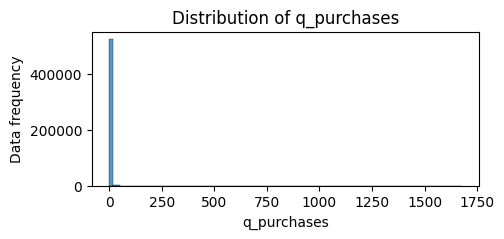

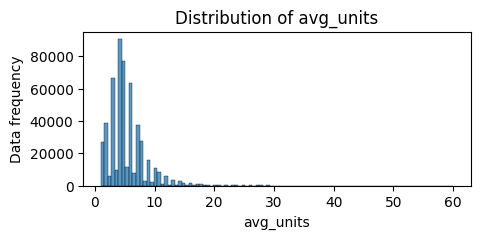

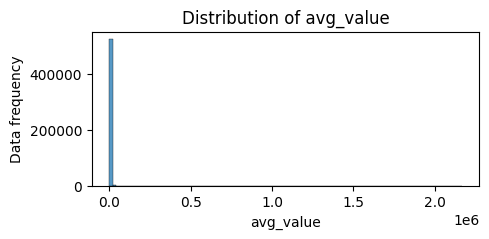

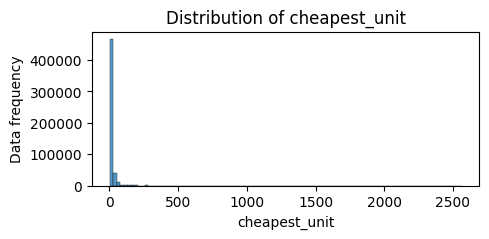

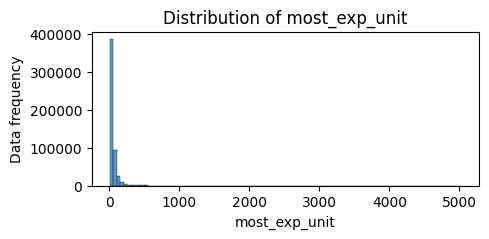

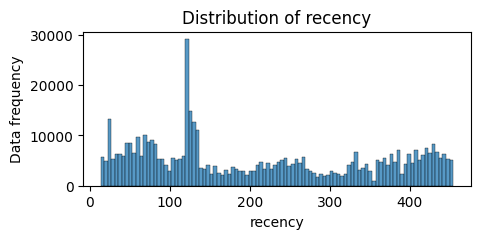

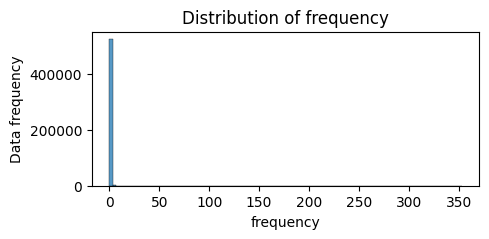

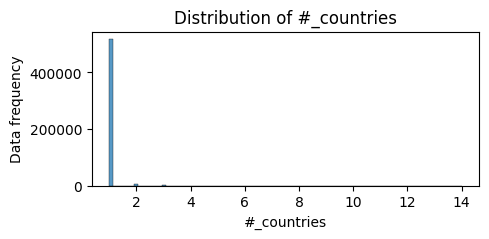

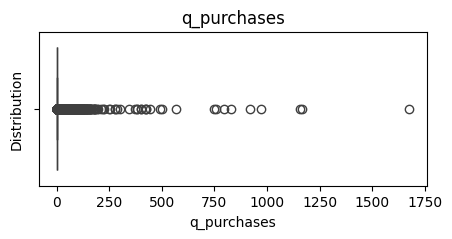

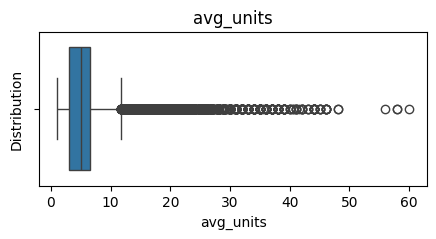

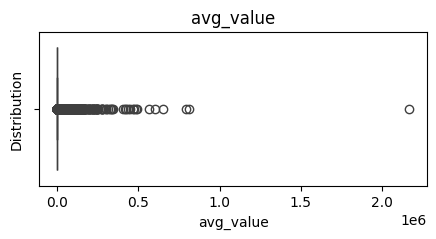

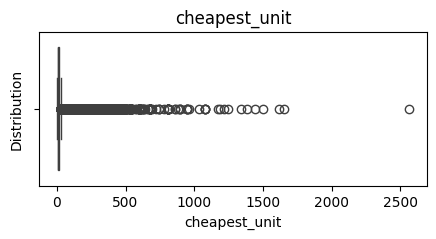

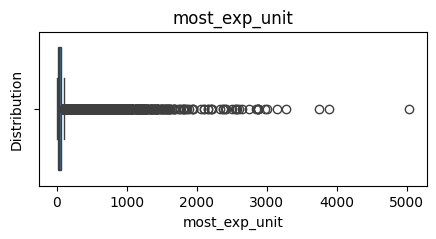

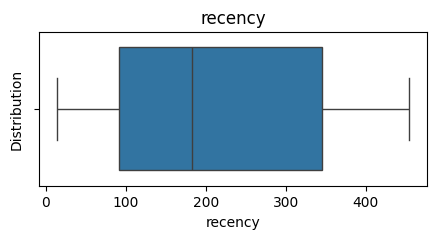

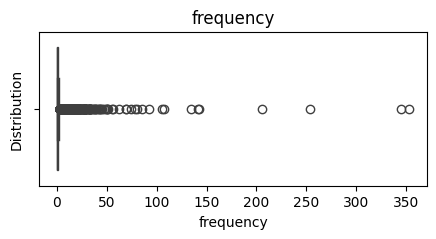

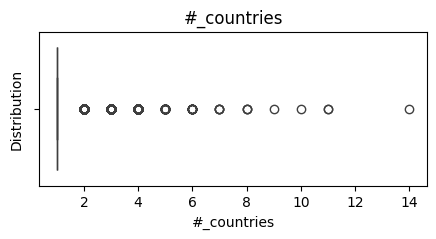

In [385]:
# Histplot with every variable
variables = ['q_purchases', 'avg_units', 'avg_value', 'cheapest_unit', 'most_exp_unit', 'recency', 'frequency', '#_countries']

for v in variables:
    plt.figure(figsize=(5, 2))
    sns.histplot(x=df_clustering[v], bins=100)
    plt.title(f'Distribution of {v}')
    plt.xlabel(v)
    plt.ylabel('Data frequency')
    plt.show()

for v in variables:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=df_clustering[v])
    plt.title(f'{v}')
    plt.xlabel(v)
    plt.ylabel('Distribution')
    plt.show()

In [386]:
# q_purchases outliers
df_clustering[df_clustering['q_purchases']>500].describe()

,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
count,11.00000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,917.00000,2.343690,4517.627157,2.226364,622.721818,62.818182,74.090909,3.545455
std,326.88836,1.726718,7370.769158,1.251313,294.422256,38.561167,88.047095,2.252272
min,502.00000,1.024893,447.340897,0.750000,335.580000,15.000000,0.000000,1.000000
25%,752.00000,1.339266,1013.441957,1.425000,415.865000,39.000000,9.000000,2.000000
50%,827.00000,1.653280,2406.518673,1.800000,540.450000,43.000000,35.000000,3.000000
75%,1064.00000,2.554310,3756.784713,2.805000,705.885000,92.000000,113.000000,5.000000
max,1676.00000,7.138705,26088.143616,5.250000,1350.000000,123.000000,254.000000,8.000000


In [387]:
# Dropping outliers
df_wo_outliers = df_clustering

df_wo_outliers = df_wo_outliers[df_wo_outliers['q_purchases'] <= 500]
df_wo_outliers.describe()

,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
count,525159.000000,525159.000000,5.251590e+05,525159.000000,525159.000000,525159.000000,525159.000000,525159.000000
mean,1.537965,5.323201,7.440358e+02,14.465715,46.671470,212.919051,0.312543,1.015510
std,3.393488,3.096275,5.584616e+03,26.296412,64.744728,137.519236,1.106826,0.145349
min,1.000000,1.000000,3.750000e+00,0.660000,1.310000,14.000000,0.000000,1.000000
25%,1.000000,3.000000,6.723000e+01,5.220000,17.850000,92.000000,0.000000,1.000000
50%,1.000000,5.000000,1.738800e+02,8.370000,29.340000,183.000000,0.000000,1.000000
75%,1.000000,6.500000,4.852800e+02,14.970000,53.910000,345.000000,1.000000,1.000000
max,490.000000,60.000000,2.165712e+06,2564.430000,5033.700000,454.000000,353.000000,14.000000


In [388]:
# avg_value outliers
df_wo_outliers[df_wo_outliers['avg_value']>500000]

,CustomerId,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
44477,3Oo8hxD2eWEF4Y8Dgj3ftw==,2,3.00,792451.320,382.20,2579.31,140,0.0,1
140355,F2XL/MjLFJlZo2bOCSG+PQ==,1,3.00,603864.000,259.10,1548.11,38,1.0,1
167594,IMXnSDyeUPdYWz9D4J8aew==,2,2.00,2165712.000,432.00,2880.00,117,0.0,1
299838,YTMHVfSxMJJ0VFChBkedtg==,1,7.00,568512.000,150.48,645.84,38,1.0,1
454522,rKyPXYzK8pk4MuDo7g6hnA==,4,10.75,813046.425,9.00,3883.68,38,1.0,1
469535,t8zwiUJtFvHSySONbxk21Q==,2,6.00,649835.420,151.65,1927.04,16,2.0,1


In [389]:
# Dropping outliers
df_wo_outliers = df_wo_outliers[df_wo_outliers['avg_value'] <= 500000]
df_wo_outliers.describe()

,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
count,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.00000
mean,1.537959,5.323201,733.393235,14.463244,46.646365,212.920747,0.312537,1.01551
std,3.393505,3.096276,4207.632370,26.281830,64.223689,137.519018,1.106828,0.14535
min,1.000000,1.000000,3.750000,0.660000,1.310000,14.000000,0.000000,1.00000
25%,1.000000,3.000000,67.226667,5.220000,17.850000,92.000000,0.000000,1.00000
50%,1.000000,5.000000,173.870000,8.370000,29.340000,183.000000,0.000000,1.00000
75%,1.000000,6.500000,485.280000,14.970000,53.910000,345.000000,1.000000,1.00000
max,490.000000,60.000000,491226.970000,2564.430000,5033.700000,454.000000,353.000000,14.00000


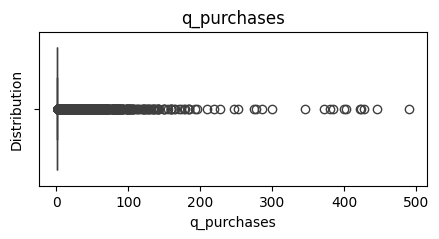

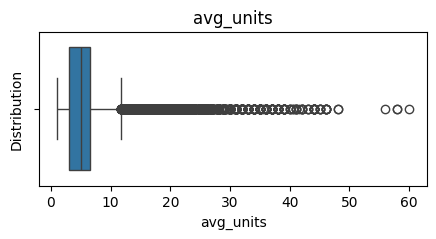

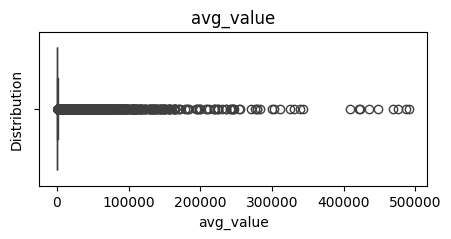

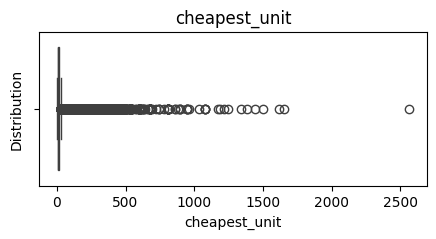

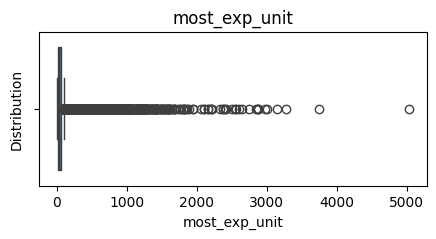

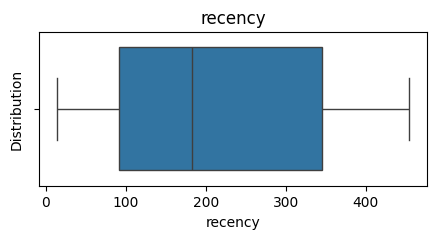

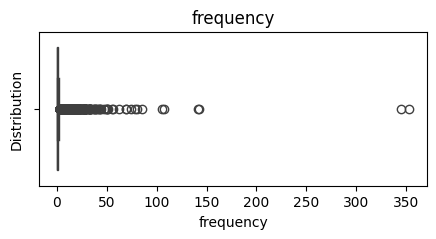

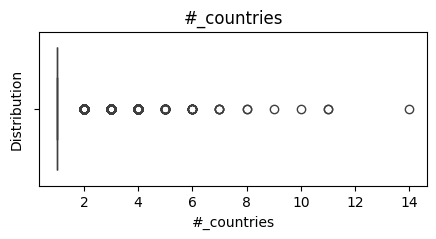

In [390]:
# Histplot with every variable
variables = ['q_purchases', 'avg_units', 'avg_value', 'cheapest_unit', 'most_exp_unit', 'recency', 'frequency', '#_countries']

for v in variables:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=df_wo_outliers[v])
    plt.title(f'{v}')
    plt.xlabel(v)
    plt.ylabel('Distribution')
    plt.show()

In [391]:
# Final dataset
df_wo_outliers.head(5)

,CustomerId,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
0,+++SJgx/2IJ+dXq7vF8COg==,1,3.0,172.21,10.48,35.95,123,0.0,1
1,+++aKiAiXhTfaqCLC/kyWA==,1,2.0,29.94,5.99,8.98,380,0.0,1
2,++/G67YHZTMKdpvANeYPLw==,1,46.0,884.61,1.35,22.50,441,0.0,2
3,++/GTDXvJzF11ZIUz81SPg==,1,3.0,59.91,5.99,20.97,216,0.0,1
4,++0Dxza60/nPDbfORBYuuA==,1,6.0,632.94,13.46,44.91,33,1.0,1


In [392]:
df_wo_outliers.describe()

,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries
count,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.00000
mean,1.537959,5.323201,733.393235,14.463244,46.646365,212.920747,0.312537,1.01551
std,3.393505,3.096276,4207.632370,26.281830,64.223689,137.519018,1.106828,0.14535
min,1.000000,1.000000,3.750000,0.660000,1.310000,14.000000,0.000000,1.00000
25%,1.000000,3.000000,67.226667,5.220000,17.850000,92.000000,0.000000,1.00000
50%,1.000000,5.000000,173.870000,8.370000,29.340000,183.000000,0.000000,1.00000
75%,1.000000,6.500000,485.280000,14.970000,53.910000,345.000000,1.000000,1.00000
max,490.000000,60.000000,491226.970000,2564.430000,5033.700000,454.000000,353.000000,14.00000


# Clustering

## RFM

In [393]:
# Create a copy of the df, to avoid permanent changes in the original df that will be used in other parts
df_rfm = df_wo_outliers

In [394]:
# Create a score for recency, frequency and monetary (avg_value)
df_rfm['R'] = pd.qcut(df_rfm['recency'], 4, labels = range(4, 0, -1))
df_rfm['R'] = df_rfm['R'].astype('int64')

df_rfm['F'] = pd.qcut(df_rfm['frequency'], 200, duplicates = "drop", labels = range(1, 5))
df_rfm['F'] = df_rfm['F'].astype('int64')

df_rfm['M'] = pd.qcut(df_rfm['avg_value'], 4, labels = range(1, 5))
df_rfm['M'] = df_rfm['M'].astype('int64')

In [395]:
# Add the RFM score
df_rfm['RFM'] = df_rfm['R'].astype('str') + df_rfm['F'].astype('str') + df_rfm['M'].astype('str')
df_rfm['RFM_score'] = df_rfm['R'] + df_rfm['F'] + df_rfm['M']

df_rfm.head(5)

,CustomerId,q_purchases,avg_units,avg_value,cheapest_unit,most_exp_unit,recency,frequency,#_countries,R,F,M,RFM,RFM_score
0,+++SJgx/2IJ+dXq7vF8COg==,1,3.0,172.21,10.48,35.95,123,0.0,1,3,1,2,312,6
1,+++aKiAiXhTfaqCLC/kyWA==,1,2.0,29.94,5.99,8.98,380,0.0,1,1,1,1,111,3
2,++/G67YHZTMKdpvANeYPLw==,1,46.0,884.61,1.35,22.50,441,0.0,2,1,1,4,114,6
3,++/GTDXvJzF11ZIUz81SPg==,1,3.0,59.91,5.99,20.97,216,0.0,1,2,1,1,211,4
4,++0Dxza60/nPDbfORBYuuA==,1,6.0,632.94,13.46,44.91,33,1.0,1,4,1,4,414,9


In [396]:
# Create a new df with the results of the RFM
rfm_results = df_rfm.groupby(by = 'RFM_score').agg({
    'CustomerId': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'avg_value': 'mean'
})

rfm_results = rfm_results.reset_index()

rfm_results = rfm_results[['RFM_score', 'CustomerId', 'recency', 'frequency', 'avg_value']]

rfm_results = rfm_results.rename(columns={
    'CustomerId': '# customers',
    'avg_value': 'monetary'
})

rfm_results = rfm_results.drop(columns = {'RFM_score'})

rfm_results

,# customers,recency,frequency,monetary
0,46272,404.475039,0.000000,43.639250
1,64967,327.193637,0.000000,77.720261
2,83676,286.287287,0.007374,164.741479
3,123275,201.684916,0.235903,444.451197
4,93709,150.897448,0.334525,882.784259
5,71164,95.293660,0.497738,1511.553437
6,33950,51.778203,1.109102,2635.808272
7,5063,44.126802,2.175588,2985.793324
8,1431,40.719776,3.433263,3282.149649
9,1646,38.728433,8.554678,6019.418567


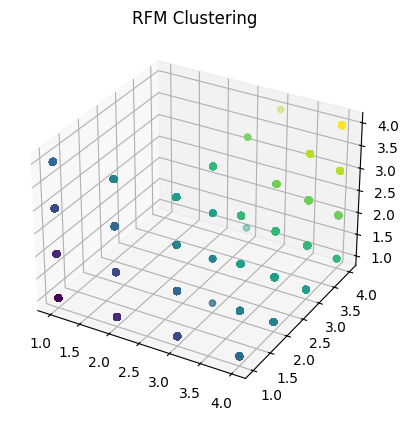

In [397]:
# Plot the final score

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

rfm_plot = ax.scatter(df_rfm['R'], df_rfm['F'], df_rfm['M'], c=df_rfm['RFM_score'], cmap='viridis')

ax.set_title('RFM Clustering')

plt.show()

In [398]:
# Polar plot of the different clusters:

# Normalize data with MinMaxScaler
scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm_results)
rfm_normalized = pd.DataFrame(rfm_normalized, columns=rfm_results.columns)

# Calculation of angles:
categories = list(rfm_normalized.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

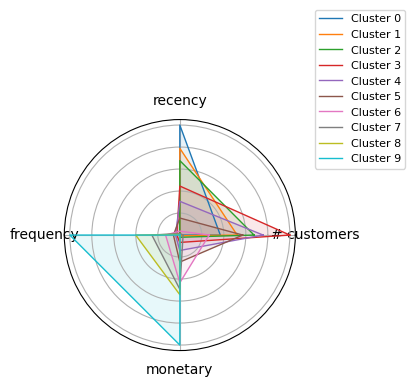

In [399]:
# Plot before iteration
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Iteration for each cluster
for i in clusters:
    # Values for plotting:
    values = rfm_normalized.iloc[i].tolist()
    values += values[:1]

    # Line and shape below line
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

# Labels of each vertex
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, )
ax.yaxis.set_tick_params(labelleft=False)

# Add colour references
ax.legend(loc = 'best', bbox_to_anchor=(1.5, 1.5), fontsize = 8)

# Show plot
plt.show()

In [400]:
# Add percentage of number of customers to the table
rfm_results['percentage'] = rfm_results['# customers'] / rfm_results['# customers'].sum()

rfm_results = rfm_results[['# customers', 'percentage', 'recency', 'frequency', 'monetary']]

rfm_results

,# customers,percentage,recency,frequency,monetary
0,46272,0.088111,404.475039,0.000000,43.639250
1,64967,0.123711,327.193637,0.000000,77.720261
2,83676,0.159336,286.287287,0.007374,164.741479
3,123275,0.234741,201.684916,0.235903,444.451197
4,93709,0.178441,150.897448,0.334525,882.784259
5,71164,0.135511,95.293660,0.497738,1511.553437
6,33950,0.064648,51.778203,1.109102,2635.808272
7,5063,0.009641,44.126802,2.175588,2985.793324
8,1431,0.002725,40.719776,3.433263,3282.149649
9,1646,0.003134,38.728433,8.554678,6019.418567


## K-Mean with RFM

### Data normalization

In [401]:
# Copy dataframe and correct titles
df_rfm_kmean = df_wo_outliers[['CustomerId', 'recency', 'frequency', 'avg_value']]

df_rfm_kmean = df_rfm_kmean.rename(columns = {'avg_value': 'monetary'})

In [402]:
# Apply log to variables
df_rfm_kmean['log_recency'] = np.log1p(df_rfm_kmean['recency'])
df_rfm_kmean['log_frequency'] = np.log1p(df_rfm_kmean['frequency'])
df_rfm_kmean['log_monetary'] = np.log1p(df_rfm_kmean['monetary'])


df_rfm_kmean.describe()

,recency,frequency,monetary,log_recency,log_frequency,log_monetary
count,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000,525153.000000
mean,212.920747,0.312537,733.393235,5.081770,0.194201,5.335075
std,137.519018,1.106828,4207.632370,0.837836,0.347926,1.348818
min,14.000000,0.000000,3.750000,2.708050,0.000000,1.558145
25%,92.000000,0.000000,67.226667,4.532599,0.000000,4.222835
50%,183.000000,0.000000,173.870000,5.214936,0.000000,5.164043
75%,345.000000,1.000000,485.280000,5.846439,0.693147,6.186785
max,454.000000,353.000000,491226.970000,6.120297,5.869297,13.104664


### Elbow Method

In [403]:
# We run the Cluster Analysis using Cluster as 1 till 12. Also, we store the WSS Scores. The WSS score will be used to create the Elbow Plot
# WSS = Within-Cluster-Sum of Squared
K = range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(df_rfm_kmean[['recency', 'frequency', 'monetary']])
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [404]:
# We Store the Number of clusters along with their WSS Scores in a DataFrame
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

,Clusters,WSS
0,1,9.307312e+12
1,2,4.461656e+12
2,3,2.551258e+12
3,4,1.638176e+12
4,5,1.083770e+12
5,6,8.035876e+11
6,7,5.708319e+11
7,8,4.390278e+11
8,9,3.413259e+11
9,10,2.793797e+11


([<matplotlib.axis.XTick at 0x127041343e0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

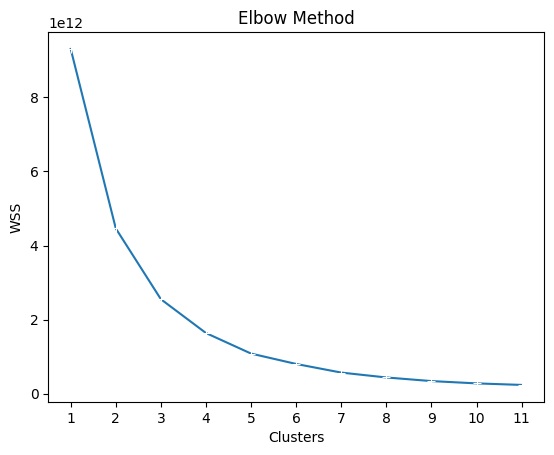

In [405]:
# Plot Elbow Method
sns.lineplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")
plt.title('Elbow Method')
plt.xticks(range(1, len(mycenters) + 1))

With the **Elbow Method** there is **no clear conclusion**, so a **Silhouette Method** will be used to obtain an optimal k for clustering.

### Silhouette Method

In [406]:
# Using log in all variables
clusters = range(3,15)
sil_score = []
for i in clusters:
    labels = cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_rfm_kmean[['log_recency', 'log_frequency', 'log_monetary']]).labels_
    score = metrics.silhouette_score(df_rfm_kmean[['log_recency', 'log_frequency', 'log_monetary']],labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)

sil_centers = pd.DataFrame({'Clusters' : clusters, 'Sil Score' : sil_score})

max_index = sil_centers['Sil Score'].idxmax()

sil_centers['max'] = ' '
sil_centers.loc[max_index, 'max'] = 'Yes'

sil_centers

,Clusters,Sil Score,max
0,3,0.417270,Yes
1,4,0.402877,
2,5,0.393159,
3,6,0.382120,
4,7,0.367308,
5,8,0.390258,
6,9,0.399173,
7,10,0.407942,
8,11,0.406498,
9,12,0.412970,


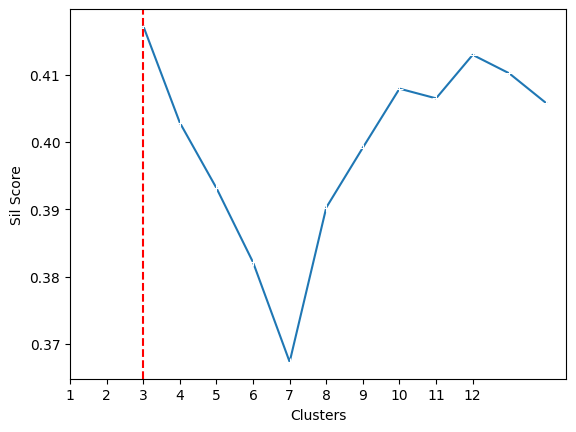

In [407]:
# Plot silhouette method
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")
plt.xticks(range(1, len(sil_centers) + 1))

plt.axvline(x = 3, color='r', linestyle='--')

In [408]:
# Using log in recency and monetary
clusters = range(3,15)
sil_score = []
for i in clusters:
    labels = cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_rfm_kmean[['log_recency', 'frequency', 'log_monetary']]).labels_
    score = metrics.silhouette_score(df_rfm_kmean[['log_recency', 'frequency', 'log_monetary']],labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)

sil_centers = pd.DataFrame({'Clusters' : clusters, 'Sil Score' : sil_score})

max_index = sil_centers['Sil Score'].idxmax()

sil_centers['max'] = ' '
sil_centers.loc[max_index, 'max'] = 'Yes'

sil_centers

,Clusters,Sil Score,max
0,3,0.411974,
1,4,0.436989,
2,5,0.437311,Yes
3,6,0.424959,
4,7,0.424284,
5,8,0.423018,
6,9,0.391150,
7,10,0.373841,
8,11,0.393756,
9,12,0.397870,


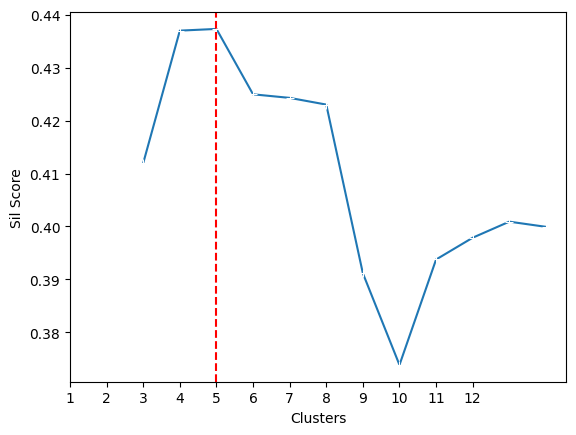

In [409]:
# Plot silhouette method
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")
plt.xticks(range(1, len(sil_centers) + 1))

plt.axvline(x = 5, color='r', linestyle='--')

In [410]:
# Using original values
clusters = range(3,15)
sil_score = []
for i in clusters:
    labels = cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_rfm_kmean[['recency', 'frequency', 'monetary']]).labels_
    score = metrics.silhouette_score(df_rfm_kmean[['recency', 'frequency', 'monetary']],labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)

sil_centers = pd.DataFrame({'Clusters' : clusters, 'Sil Score' : sil_score})

max_index = sil_centers['Sil Score'].idxmax()

sil_centers['max'] = ' '
sil_centers.loc[max_index, 'max'] = 'Yes'

sil_centers

,Clusters,Sil Score,max
0,3,0.956600,Yes
1,4,0.950384,
2,5,0.934212,
3,6,0.922179,
4,7,0.851576,
5,8,0.835008,
6,9,0.804957,
7,10,0.748110,
8,11,0.747558,
9,12,0.726181,


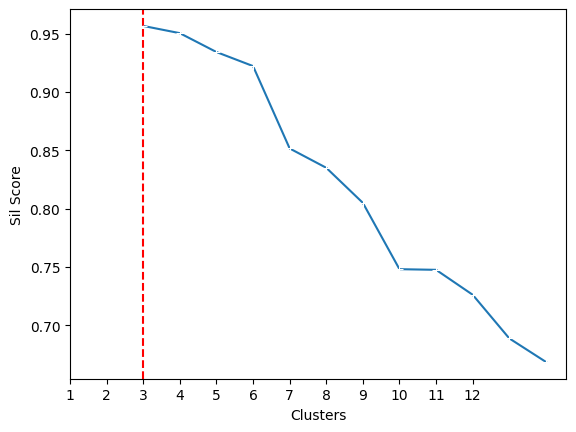

In [411]:
# Plot silhouette method
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")
plt.xticks(range(1, len(sil_centers) + 1))

plt.axvline(x = 3, color='r', linestyle='--')

### Perform K-Mean with K = 3 (original values)

In [412]:
# Fit k-means to the dataset for k= 3 clusters
kmeans = cluster.KMeans(n_clusters = 3 ,init="k-means++")
kmeans = kmeans.fit(df_rfm_kmean[['recency', 'frequency', 'monetary']])

df_rfm_kmean['Clusters'] = kmeans.labels_

df_rfm_kmean.head(5)

,CustomerId,recency,frequency,monetary,log_recency,log_frequency,log_monetary,Clusters
0,+++SJgx/2IJ+dXq7vF8COg==,123,0.0,172.21,4.820282,0.000000,5.154505,0
1,+++aKiAiXhTfaqCLC/kyWA==,380,0.0,29.94,5.942799,0.000000,3.432050,0
2,++/G67YHZTMKdpvANeYPLw==,441,0.0,884.61,6.091310,0.000000,6.786277,0
3,++/GTDXvJzF11ZIUz81SPg==,216,0.0,59.91,5.379897,0.000000,4.109397,0
4,++0Dxza60/nPDbfORBYuuA==,33,1.0,632.94,3.526361,0.693147,6.451954,0


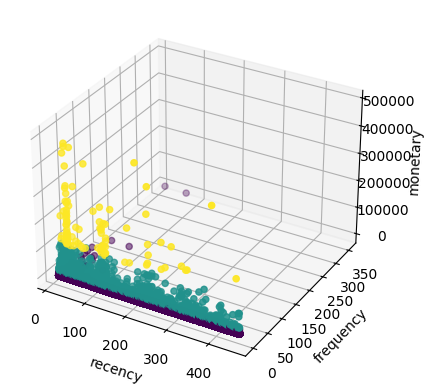

In [413]:
# Create and show plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_rfm_kmean['recency'], df_rfm_kmean['frequency'], df_rfm_kmean['monetary'], c=df_rfm_kmean['Clusters'], cmap='viridis')

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')

plt.show()

In [414]:
# Summary of this clustering
df_rfm_kmean_results = df_rfm_kmean.groupby(by = 'Clusters').agg({
    'CustomerId': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})

df_rfm_kmean_results = df_rfm_kmean_results.reset_index()
df_rfm_kmean_results

,Clusters,CustomerId,recency,frequency,monetary
0,0,523317,213.208980,0.309963,575.390246
1,1,1735,132.149280,1.053026,35984.326171
2,2,101,106.990099,0.930693,213854.988159


The results are not **logical**, with no clear conclusion for future decision making. We will try with the log model, if not change to the new option of adding **new variables**.

### Perform K-Mean with K = 5 (log in recency and monetary)

In [415]:
# Fit k-means to the dataset for k= 5 clusters
kmeans = cluster.KMeans(n_clusters = 5 ,init="k-means++")
kmeans = kmeans.fit(df_rfm_kmean[['log_recency', 'frequency', 'log_monetary']])

df_rfm_kmean['Clusters'] = kmeans.labels_

df_rfm_kmean.head(5)

,CustomerId,recency,frequency,monetary,log_recency,log_frequency,log_monetary,Clusters
0,+++SJgx/2IJ+dXq7vF8COg==,123,0.0,172.21,4.820282,0.000000,5.154505,1
1,+++aKiAiXhTfaqCLC/kyWA==,380,0.0,29.94,5.942799,0.000000,3.432050,1
2,++/G67YHZTMKdpvANeYPLw==,441,0.0,884.61,6.091310,0.000000,6.786277,0
3,++/GTDXvJzF11ZIUz81SPg==,216,0.0,59.91,5.379897,0.000000,4.109397,1
4,++0Dxza60/nPDbfORBYuuA==,33,1.0,632.94,3.526361,0.693147,6.451954,3


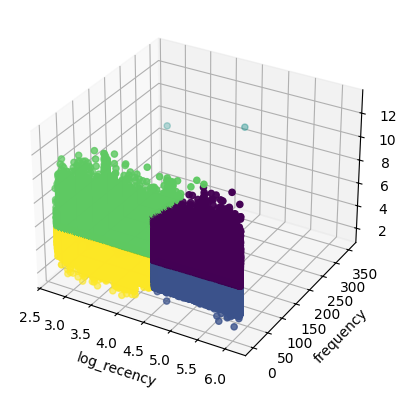

In [416]:
# Create and show plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_rfm_kmean['log_recency'], df_rfm_kmean['frequency'], df_rfm_kmean['log_monetary'], c=df_rfm_kmean['Clusters'], cmap='viridis')

ax.set_xlabel('log_recency')
ax.set_ylabel('frequency')
ax.set_zlabel('log_monetary')

plt.show()

In [417]:
# Summary of this clustering
df_rfm_kmean_results = df_rfm_kmean.groupby(by = 'Clusters').agg({
    'CustomerId': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})

df_rfm_kmean_results = df_rfm_kmean_results.rename(columns = {
    'CustomerId': '# customers'
})

df_rfm_kmean_results = df_rfm_kmean_results.reset_index()
df_rfm_kmean_results

,Clusters,# customers,recency,frequency,monetary
0,0,152747,248.681342,0.000000,1369.733781
1,1,237352,280.050141,0.000000,98.240705
2,2,2,46.000000,349.000000,4938.576155
3,3,50120,52.290483,1.429429,2834.593072
4,4,84932,55.800970,1.080735,123.906440


Again the results are not **logical**, with no clear conclusion for future decision making. The best clustering method is the RFM method.

## K-Mean with RFM + New Variables

### Data Normalization

In [418]:
# Copy original df to avoid permanent changes in it, and correct titles
df_rfm_v2_kmean = df_wo_outliers[['CustomerId', 'recency', 'frequency', 'avg_value', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']]

df_rfm_v2_kmean = df_rfm_v2_kmean.rename(columns = {'avg_value': 'monetary'})

df_rfm_v2_kmean.head(5)

,CustomerId,recency,frequency,monetary,avg_units,#_countries,cheapest_unit,most_exp_unit
0,+++SJgx/2IJ+dXq7vF8COg==,123,0.0,172.21,3.0,1,10.48,35.95
1,+++aKiAiXhTfaqCLC/kyWA==,380,0.0,29.94,2.0,1,5.99,8.98
2,++/G67YHZTMKdpvANeYPLw==,441,0.0,884.61,46.0,2,1.35,22.50
3,++/GTDXvJzF11ZIUz81SPg==,216,0.0,59.91,3.0,1,5.99,20.97
4,++0Dxza60/nPDbfORBYuuA==,33,1.0,632.94,6.0,1,13.46,44.91


In [419]:
# Normalize data
scaler = StandardScaler()
df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']] = scaler.fit_transform(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']])
df_rfm_v2_kmean.head(5)

,CustomerId,recency,frequency,monetary,avg_units,#_countries,cheapest_unit,most_exp_unit
0,+++SJgx/2IJ+dXq7vF8COg==,-0.653879,-0.282372,-0.133373,-0.750322,-0.106707,-0.151559,-0.166549
1,+++aKiAiXhTfaqCLC/kyWA==,1.214955,-0.282372,-0.167185,-1.073291,-0.106707,-0.322400,-0.586488
2,++/G67YHZTMKdpvANeYPLw==,1.658530,-0.282372,0.035939,13.137344,6.773250,-0.498948,-0.375973
3,++/GTDXvJzF11ZIUz81SPg==,0.022391,-0.282372,-0.160062,-0.750322,-0.106707,-0.322400,-0.399796
4,++0Dxza60/nPDbfORBYuuA==,-1.308335,0.621111,-0.023874,0.218585,-0.106707,-0.038173,-0.027036


### Elbow Method

In [420]:
# We run the Cluster Analysis using Cluster as 1 till 12. Also, we store the WSS Scores. The WSS score will be used to create the Elbow Plot
# WSS = Within-Cluster-Sum of Squared
K = range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']])
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [421]:
# We Store the Number of clusters along with their WSS Scores in a DataFrame
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

,Clusters,WSS
0,1,3.676071e+06
1,2,3.185657e+06
2,3,2.741250e+06
3,4,2.323244e+06
4,5,2.054126e+06
5,6,1.845008e+06
6,7,1.727436e+06
7,8,1.601041e+06
8,9,1.400950e+06
9,10,1.339963e+06


([<matplotlib.axis.XTick at 0x1270b0c2870>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

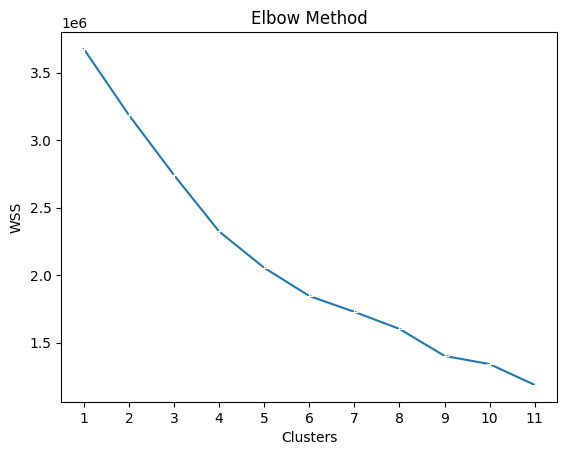

In [422]:
# Plot Elbow Method
sns.lineplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")
plt.title('Elbow Method')
plt.xticks(range(1, len(mycenters) + 1))

With the **Elbow Method** there is **no clear conclusion**, so a **Silhouette Method** will be used to obtain an optimal k for clustering.

### Silhouette Method

In [423]:
# Using all variables
clusters = range(2,15)
sil_score = []
for i in clusters:
    labels = cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']]).labels_
    score = metrics.silhouette_score(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']],labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)

sil_centers = pd.DataFrame({'Clusters' : clusters, 'Sil Score' : sil_score})

max_index = sil_centers['Sil Score'].idxmax()

sil_centers['max'] = ' '
sil_centers.loc[max_index, 'max'] = 'Yes'

sil_centers

,Clusters,Sil Score,max
0,2,0.304760,
1,3,0.325787,
2,4,0.345596,
3,5,0.351606,
4,6,0.355789,
5,7,0.355789,
6,8,0.369059,
7,9,0.368720,
8,10,0.374520,Yes
9,11,0.319821,


**Silhouette scores are really low**, meaning that objects **are not highly similar to their own clusters**. We will **exclude variables that may not be so important as cheapest and most expensive units**.

In [424]:
# Excluding cheapest and most expensive variables to see if the silhouette score improves
clusters = range(2,15)
sil_score = []
for i in clusters:
    labels = cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries']]).labels_
    score = metrics.silhouette_score(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries']],labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)

sil_centers = pd.DataFrame({'Clusters' : clusters, 'Sil Score' : sil_score})

max_index = sil_centers['Sil Score'].idxmax()
cluster_max = 1 # Created to ad a Yes to the cluster K=3 as it has same results as K=2

sil_centers['max'] = ' '
sil_centers.loc[max_index, 'max'] = 'Yes'
sil_centers.loc[cluster_max, 'max'] = 'Yes'

sil_centers

,Clusters,Sil Score,max
0,2,0.788286,Yes
1,3,0.788286,Yes
2,4,0.411440,
3,5,0.429291,
4,6,0.387426,
5,7,0.387426,
6,8,0.387426,
7,9,0.386878,
8,10,0.388422,
9,11,0.373619,


As the **silhouette score improved significantly**, we will continue with this model, **excludign variables cheapest_unit and most_exp_unit**.

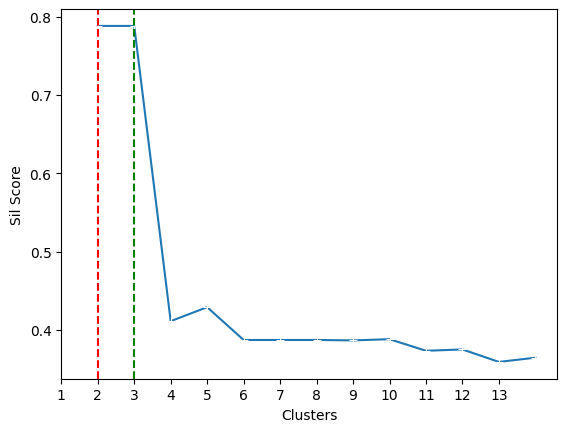

In [425]:
# Plot silhouette method
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")
plt.xticks(range(1, len(sil_centers) + 1))

plt.axvline(x = 2, color='r', linestyle='--')
plt.axvline(x = 3, color='g', linestyle='--')

Although 2 and 3 are optimal Ks, **we will use K=3** as the dataset is really complex and more clustering may be more detailed, and there are not hughe differences between 2 and 3.

### Perform K-Mean with K = 3

In [426]:
# Fit k-mean to the df
kmeans = cluster.KMeans(n_clusters = 3 ,init="k-means++")
kmeans = kmeans.fit(df_rfm_v2_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries']])

df_rfm_v2_kmean['Clusters'] = kmeans.labels_

In [427]:
# Concatenate clusters to original table
df_results_rfm_more = pd.merge(df_wo_outliers, df_rfm_v2_kmean, how = 'left', on = 'CustomerId')
df_results_rfm_more.head(5)

,CustomerId,q_purchases,avg_units_x,avg_value,cheapest_unit_x,most_exp_unit_x,recency_x,frequency_x,#_countries_x,R,...,RFM,RFM_score,recency_y,frequency_y,monetary,avg_units_y,#_countries_y,cheapest_unit_y,most_exp_unit_y,Clusters
0,+++SJgx/2IJ+dXq7vF8COg==,1,3.0,172.21,10.48,35.95,123,0.0,1,3,...,312,6,-0.653879,-0.282372,-0.133373,-0.750322,-0.106707,-0.151559,-0.166549,1
1,+++aKiAiXhTfaqCLC/kyWA==,1,2.0,29.94,5.99,8.98,380,0.0,1,1,...,111,3,1.214955,-0.282372,-0.167185,-1.073291,-0.106707,-0.322400,-0.586488,0
2,++/G67YHZTMKdpvANeYPLw==,1,46.0,884.61,1.35,22.50,441,0.0,2,1,...,114,6,1.658530,-0.282372,0.035939,13.137344,6.773250,-0.498948,-0.375973,2
3,++/GTDXvJzF11ZIUz81SPg==,1,3.0,59.91,5.99,20.97,216,0.0,1,2,...,211,4,0.022391,-0.282372,-0.160062,-0.750322,-0.106707,-0.322400,-0.399796,1
4,++0Dxza60/nPDbfORBYuuA==,1,6.0,632.94,13.46,44.91,33,1.0,1,4,...,414,9,-1.308335,0.621111,-0.023874,0.218585,-0.106707,-0.038173,-0.027036,1


In [428]:
# Change variables' names
df_results_rfm_more = df_results_rfm_more[['CustomerId', 'Clusters', 'recency_x', 'frequency_x', 'avg_value', 'avg_units_x', '#_countries_x']]
df_results_rfm_more = df_results_rfm_more.rename(columns = {
    'CustomerId': '# customers',
    'Clusters': 'cluster',
    'recency_x': 'recency',
    'frequency_x': 'frequency',
    'avg_value': 'monetary',
    'avg_units_x': 'avg_units',
    '#_countries_x': '#_countries'
})
df_results_rfm_more.head(5)

,# customers,cluster,recency,frequency,monetary,avg_units,#_countries
0,+++SJgx/2IJ+dXq7vF8COg==,1,123,0.0,172.21,3.0,1
1,+++aKiAiXhTfaqCLC/kyWA==,0,380,0.0,29.94,2.0,1
2,++/G67YHZTMKdpvANeYPLw==,2,441,0.0,884.61,46.0,2
3,++/GTDXvJzF11ZIUz81SPg==,1,216,0.0,59.91,3.0,1
4,++0Dxza60/nPDbfORBYuuA==,1,33,1.0,632.94,6.0,1


In [429]:
# Summary of this clustering
df_results_rfm_more = df_results_rfm_more.groupby(by = 'cluster').agg({
    '# customers': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'avg_units': 'mean',
    '#_countries': 'mean'
})

df_results_rfm_more = df_results_rfm_more.reset_index()

df_results_rfm_more = df_results_rfm_more.drop(columns = {'cluster'})

df_results_rfm_more

,# customers,recency,frequency,monetary,avg_units,#_countries
0,238015,346.990833,0.000008,477.896282,5.685253,1.000000
1,279914,101.286999,0.548008,866.611574,4.947566,1.000000
2,7224,121.165144,1.485742,3989.543395,7.949427,2.127492


In [430]:
# Polar plot of the different clusters:

# Normalize data
scaler = StandardScaler()
df_results_rfm_more_norm = scaler.fit_transform(df_results_rfm_more)
df_results_rfm_more_norm = pd.DataFrame(df_results_rfm_more_norm, columns=df_results_rfm_more.columns)

# Calculation of angles:
categories = list(df_results_rfm_more_norm.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

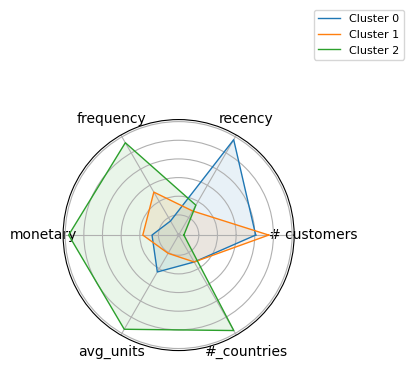

In [431]:
# Plot before iteration
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

clusters = [0, 1, 2]

# Iteration for each cluster
for i in clusters:
    # Values for plotting:
    values = df_results_rfm_more_norm.iloc[i].tolist()
    values += values[:1]

    # Line and shape below line
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

# Labels of each vertex
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, )
ax.yaxis.set_tick_params(labelleft=False)

# Add legend
ax.legend(loc = 'best', bbox_to_anchor=(1.5, 1.5), fontsize = 8)

# Show plot
plt.show()

In [432]:
df_results_rfm_more['percentage'] = df_results_rfm_more['# customers'] / df_results_rfm_more['# customers'].sum()

df_results_rfm_more = df_results_rfm_more[['# customers', 'percentage', 'recency', 'frequency', 'monetary', 'avg_units', '#_countries']]

df_results_rfm_more

,# customers,percentage,recency,frequency,monetary,avg_units,#_countries
0,238015,0.453230,346.990833,0.000008,477.896282,5.685253,1.000000
1,279914,0.533014,101.286999,0.548008,866.611574,4.947566,1.000000
2,7224,0.013756,121.165144,1.485742,3989.543395,7.949427,2.127492


### Try with k = 2

In [433]:
# Copy original df to avoid permanent changes in it, and correct titles
df_rfm_v3_kmean = df_wo_outliers[['CustomerId', 'recency', 'frequency', 'avg_value', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']]

df_rfm_v3_kmean = df_rfm_v3_kmean.rename(columns = {'avg_value': 'monetary'})

# Normalize data
scaler = StandardScaler()
df_rfm_v3_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']] = scaler.fit_transform(df_rfm_v3_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries', 'cheapest_unit', 'most_exp_unit']])

df_rfm_v3_kmean.head(5)

,CustomerId,recency,frequency,monetary,avg_units,#_countries,cheapest_unit,most_exp_unit
0,+++SJgx/2IJ+dXq7vF8COg==,-0.653879,-0.282372,-0.133373,-0.750322,-0.106707,-0.151559,-0.166549
1,+++aKiAiXhTfaqCLC/kyWA==,1.214955,-0.282372,-0.167185,-1.073291,-0.106707,-0.322400,-0.586488
2,++/G67YHZTMKdpvANeYPLw==,1.658530,-0.282372,0.035939,13.137344,6.773250,-0.498948,-0.375973
3,++/GTDXvJzF11ZIUz81SPg==,0.022391,-0.282372,-0.160062,-0.750322,-0.106707,-0.322400,-0.399796
4,++0Dxza60/nPDbfORBYuuA==,-1.308335,0.621111,-0.023874,0.218585,-0.106707,-0.038173,-0.027036


In [434]:
# Fit k-mean to the df
kmeans = cluster.KMeans(n_clusters = 2 ,init="k-means++")
kmeans = kmeans.fit(df_rfm_v3_kmean[['recency', 'frequency', 'monetary', 'avg_units', '#_countries']])

df_rfm_v3_kmean['Clusters'] = kmeans.labels_

In [435]:
# Concatenate clusters to original table
df_results_rfm_more_v2 = pd.merge(df_wo_outliers, df_rfm_v3_kmean, how = 'left', on = 'CustomerId')
df_results_rfm_more_v2.head(5)

,CustomerId,q_purchases,avg_units_x,avg_value,cheapest_unit_x,most_exp_unit_x,recency_x,frequency_x,#_countries_x,R,...,RFM,RFM_score,recency_y,frequency_y,monetary,avg_units_y,#_countries_y,cheapest_unit_y,most_exp_unit_y,Clusters
0,+++SJgx/2IJ+dXq7vF8COg==,1,3.0,172.21,10.48,35.95,123,0.0,1,3,...,312,6,-0.653879,-0.282372,-0.133373,-0.750322,-0.106707,-0.151559,-0.166549,0
1,+++aKiAiXhTfaqCLC/kyWA==,1,2.0,29.94,5.99,8.98,380,0.0,1,1,...,111,3,1.214955,-0.282372,-0.167185,-1.073291,-0.106707,-0.322400,-0.586488,0
2,++/G67YHZTMKdpvANeYPLw==,1,46.0,884.61,1.35,22.50,441,0.0,2,1,...,114,6,1.658530,-0.282372,0.035939,13.137344,6.773250,-0.498948,-0.375973,1
3,++/GTDXvJzF11ZIUz81SPg==,1,3.0,59.91,5.99,20.97,216,0.0,1,2,...,211,4,0.022391,-0.282372,-0.160062,-0.750322,-0.106707,-0.322400,-0.399796,0
4,++0Dxza60/nPDbfORBYuuA==,1,6.0,632.94,13.46,44.91,33,1.0,1,4,...,414,9,-1.308335,0.621111,-0.023874,0.218585,-0.106707,-0.038173,-0.027036,0


In [436]:
# Change variables' names
df_results_rfm_more_v2 = df_results_rfm_more_v2[['CustomerId', 'Clusters', 'recency_x', 'frequency_x', 'avg_value', 'avg_units_x', '#_countries_x']]
df_results_rfm_more_v2 = df_results_rfm_more_v2.rename(columns = {
    'CustomerId': '# customers',
    'Clusters': 'cluster',
    'recency_x': 'recency',
    'frequency_x': 'frequency',
    'avg_value': 'monetary',
    'avg_units_x': 'avg_units',
    '#_countries_x': '#_countries'
})
df_results_rfm_more_v2.head(5)

,# customers,cluster,recency,frequency,monetary,avg_units,#_countries
0,+++SJgx/2IJ+dXq7vF8COg==,0,123,0.0,172.21,3.0,1
1,+++aKiAiXhTfaqCLC/kyWA==,0,380,0.0,29.94,2.0,1
2,++/G67YHZTMKdpvANeYPLw==,1,441,0.0,884.61,46.0,2
3,++/GTDXvJzF11ZIUz81SPg==,0,216,0.0,59.91,3.0,1
4,++0Dxza60/nPDbfORBYuuA==,0,33,1.0,632.94,6.0,1


In [437]:
# Summary of this clustering
df_results_rfm_more_v2 = df_results_rfm_more_v2.groupby(by = 'cluster').agg({
    '# customers': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'avg_units': 'mean',
    '#_countries': 'mean'
})

df_results_rfm_more_v2 = df_results_rfm_more_v2.reset_index()

df_results_rfm_more_v2 = df_results_rfm_more_v2.drop(columns = {'cluster'})

df_results_rfm_more_v2

,# customers,recency,frequency,monetary,avg_units,#_countries
0,517867,214.215362,0.295765,672.198526,5.286374,1.000000
1,7286,120.903376,1.504666,5082.929347,7.940783,2.117897


In [438]:
# Polar plot of the different clusters:

# Normalize data
scaler = StandardScaler()
df_results_rfm_more_v2_norm = scaler.fit_transform(df_results_rfm_more_v2)
df_results_rfm_more_v2_norm = pd.DataFrame(df_results_rfm_more_v2_norm, columns=df_results_rfm_more_v2.columns)

# Calculation of angles:
categories = list(df_results_rfm_more_v2_norm.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

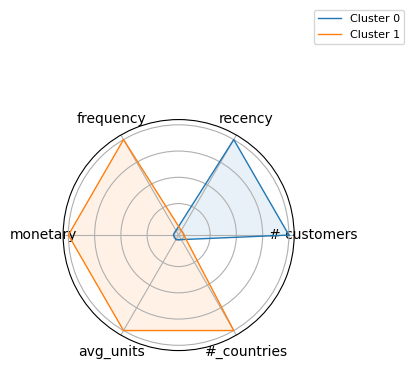

In [439]:
# Plot before iteration
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

clusters = [0, 1]

# Iteration for each cluster
for i in clusters:
    # Values for plotting:
    values = df_results_rfm_more_v2_norm.iloc[i].tolist()
    values += values[:1]

    # Line and shape below line
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

# Labels of each vertex
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, )
ax.yaxis.set_tick_params(labelleft=False)

# Add legend
ax.legend(loc = 'best', bbox_to_anchor=(1.5, 1.5), fontsize = 8)

# Show plot
plt.show()

In [440]:
df_results_rfm_more_v2['percentage'] = df_results_rfm_more_v2['# customers'] / df_results_rfm_more_v2['# customers'].sum()

df_results_rfm_more_v2 = df_results_rfm_more_v2[['# customers', 'percentage', 'recency', 'frequency', 'monetary', 'avg_units', '#_countries']]

df_results_rfm_more_v2

,# customers,percentage,recency,frequency,monetary,avg_units,#_countries
0,517867,0.986126,214.215362,0.295765,672.198526,5.286374,1.000000
1,7286,0.013874,120.903376,1.504666,5082.929347,7.940783,2.117897
